Histopathologic Cancer Detection using Convolutional Neural Networks

1. Introduction

This project intends to create a machine learning model able to identify metastatic cancer in histological images. We will classify small image patches taken from larger digital pathology scans using a Convolutional Neural Network (CNN) to forecast whether they include cancerous tissue. The challenge specifically calls for us to create a binary classifier separating non-cancerous (label 0) from cancerous (label 1).

Data Profile:

The dataset consists of preprocessed, consistent-formatted labeled image patches all of which have been used. Important information of the dataset consists in the following:

- 176,020 training images, 96x96 pixels
- 44,005 validation images, also 96x96 pixel in scale 
- Every image is tagged as either 0 (non-cancerous) or 1 (cancerous)
- Each TIFF file that stores the images relates to a single image patch

Our goal is to develop a CNN model on this dataset such that it achieves high area under the ROC curve (AUC) and correctly labels the images as either cancerous or non-cancerous.

2. Exploratory Data Analysis (EDA)
    - 2.1 Importing Libraries
    - 2.2 Loading Data
    - 2.3 Visualizing label distribution/images
    - 2.4 Checking for Null/Missing Values
    - 2.5 Data Cleaning/Preprocessing


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

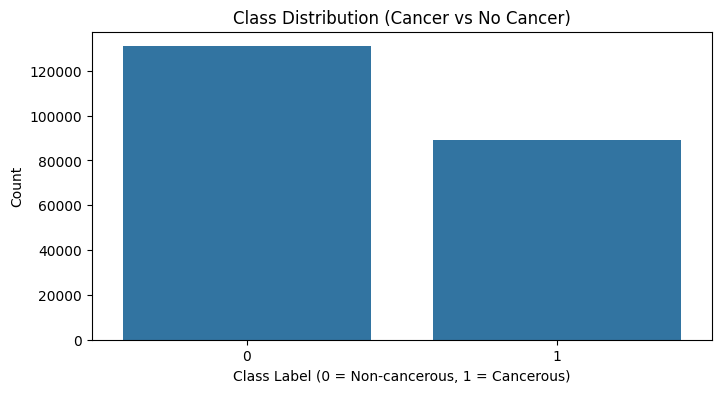

Training set size: 220025
Training set size after split: 176020
Validation set size: 44005


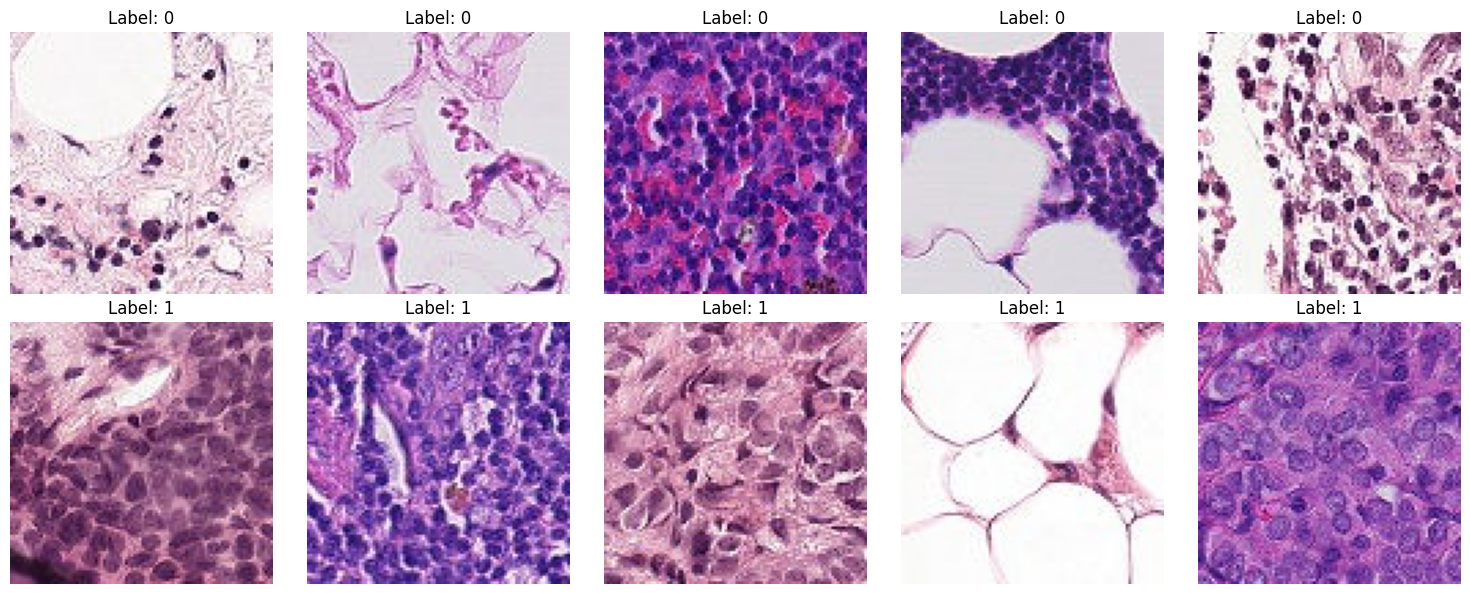

In [7]:
class_distribution = train_labels['label'].value_counts()

plt.figure(figsize=(8, 4))
sns.barplot(x=class_distribution.index, y=class_distribution.values)
plt.title('Class Distribution (Cancer vs No Cancer)')
plt.xlabel('Class Label (0 = Non-cancerous, 1 = Cancerous)')
plt.ylabel('Count')
plt.show()

print(f"Training set size: {len(train_labels)}")

train_data, val_data = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels['label'])

print(f"Training set size after split: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")

def visualize_samples(num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(num_samples*3, 6))
    cancer_labels = [0, 1]
    
    for label in cancer_labels:
        label_data = train_data[train_data['label'] == label]
        sample_ids = label_data.sample(num_samples)['id'].values
        
        for i, img_id in enumerate(sample_ids):
            img_path = f'C:/Users/abdiw/Downloads/histopathologic-cancer-detection/train/{img_id}.tif'
            img = Image.open(img_path)
            ax = axes[label, i]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Label: {label}')
    
    plt.tight_layout()
    plt.show()

visualize_samples(num_samples=5)

In [8]:
print(f"Number of missing labels: {train_labels['label'].isnull().sum()}")

available_images = set(os.listdir(train_dir))
train_labels['image_path'] = train_labels['id'] + '.tif'

missing_images = train_labels[~train_labels['image_path'].isin(available_images)]
print(f"Number of missing images: {len(missing_images)}")

train_labels = train_labels[train_labels['image_path'].isin(available_images)]

train_data, val_data = train_test_split(train_labels, test_size=0.2, random_state=42, stratify=train_labels['label'])

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    vertical_flip=True 
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

train_data['label'] = train_data['label'].astype(str)
val_data['label'] = val_data['label'].astype(str)

def generate_data(data, datagen, batch_size=32):
    return datagen.flow_from_dataframe(
        dataframe=data,
        directory=train_dir, 
        x_col='image_path',
        y_col='label',
        target_size=(96, 96),
        color_mode='rgb',
        class_mode='binary', 
        batch_size=batch_size,
        shuffle=True
    )

train_generator = generate_data(train_data, train_datagen, batch_size=32)
val_generator = generate_data(val_data, val_datagen, batch_size=32)

Number of missing labels: 0
Number of missing images: 0
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


We now split the training and validation sets and know the dataset is whole with no missing labels or images. We can then keep on defining the CNN model architecture to advance with. CNN Model Design: The images have three channels (RGB) and size of 96x96 pixels. Multiple convolutional layers preceded by ReLU activations will help us to extract spatial features. Usually, max pooling layers come next to help to lower dimensionality while still preserving significant information. Dropout layers will be included to randomly turn off neurons during training, so preventing overfitting. We will learn intricate patterns using dense layers following data flattening from the convolutional layers. Given a binary classification problem, the output layer will consist of a single neuron with a sigmoid activation to produce a probability ranging from 0 to 1.

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape=(96, 96, 3)):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = create_cnn_model()

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 47, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 22, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 10, 10, 128)      

Structure of Training Models 

- Training Objectives: 

    - Set the number of epochs (e.g., 10–20 from beginning). 

    - The data generators entered batch size as 32. 



- Callbacks: 

    - If after a few epochs validation performance does not improve, stop training using EarlyStopping. 

    - Save the best model throughout training with ModelCheckpoint. 



- Training Mechanism: 

    - Train the model with model.fit() utilizing generators for both training and validation data.

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15


5501/5501 [==============================] - 614s 111ms/step - loss: 0.4390 - accuracy: 0.8034 - val_loss: 0.4799 - val_accuracy: 0.7861
Epoch 2/15


C:\Users\abdiw\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5501/5501 [==============================] - 560s 102ms/step - loss: 0.3705 - accuracy: 0.8395 - val_loss: 0.4111 - val_accuracy: 0.8228
Epoch 3/15
5501/5501 [==============================] - 539s 98ms/step - loss: 0.3454 - accuracy: 0.8532 - val_loss: 0.4196 - val_accuracy: 0.8280
Epoch 4/15
5501/5501 [==============================] - 535s 97ms/step - loss: 0.3308 - accuracy: 0.8606 - val_loss: 0.3685 - val_accuracy: 0.8438
Epoch 5/15
5501/5501 [==============================] - 539s 98ms/step - loss: 0.3199 - accuracy: 0.8663 - val_loss: 0.3144 - val_accuracy: 0.8695
Epoch 6/15
5501/5501 [==============================] - 536s 97ms/step - loss: 0.3109 - accuracy: 0.8708 - val_loss: 0.3482 - val_accuracy: 0.8492
Epoch 7/15
5501/5501 [==============================] - 541s 98ms/step - loss: 0.3025 - accuracy: 0.8751 - val_loss: 0.3445 - val_accuracy: 0.8662
Epoch 8/15
5501/5501 [==============================] - 547s 99ms/step - loss: 0.2958 - accuracy: 0.8784 - val_loss: 0.2880 - va

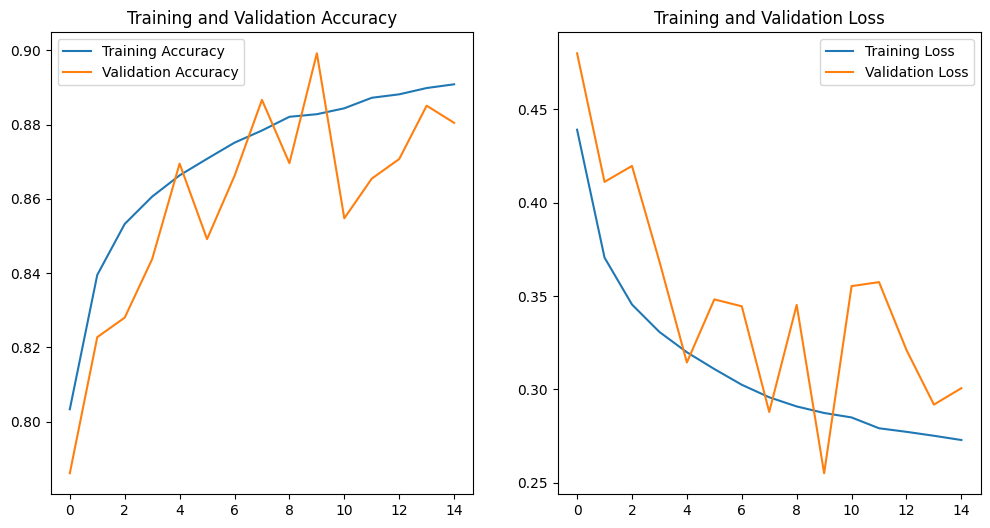

In [11]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [16]:
test_image_filenames = [f for f in os.listdir(test_dir) if f.endswith('.tif')]

test_df = pd.DataFrame({
    'id': [filename.split('.')[0] for filename in test_image_filenames],
    'image_path': test_image_filenames
})

print("Test DataFrame preview:")
print(test_df.head())

test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='image_path',
    y_col=None, 
    target_size=(96, 96),
    color_mode='rgb',
    class_mode=None,
    shuffle=False,
    batch_size=32
)

test_predictions = model.predict(test_generator)

print(f"Predictions shape: {test_predictions.shape}")
print("First 10 predictions (probabilities):")
print(test_predictions[:10])


threshold = 0.5
test_labels = (test_predictions > threshold).astype(int)

print("First 10 binary predictions (labels):")
print(test_labels[:10])

submission = pd.DataFrame({
    'id': test_df['id'], 
    'label': test_predictions.flatten() 
})

submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file saved as 'submission.csv'")


Test DataFrame preview:
                                         id  \
0  00006537328c33e284c973d7b39d340809f7271b   
1  0000ec92553fda4ce39889f9226ace43cae3364e   
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2   
3  000253dfaa0be9d0d100283b22284ab2f6b643f6   
4  000270442cc15af719583a8172c87cd2bd9c7746   

                                     image_path  
0  00006537328c33e284c973d7b39d340809f7271b.tif  
1  0000ec92553fda4ce39889f9226ace43cae3364e.tif  
2  00024a6dee61f12f7856b0fc6be20bc7a48ba3d2.tif  
3  000253dfaa0be9d0d100283b22284ab2f6b643f6.tif  
4  000270442cc15af719583a8172c87cd2bd9c7746.tif  
Found 57458 validated image filenames.
1796/1796 [==============================] - 51s 28ms/step
Predictions shape: (57458, 1)
First 10 predictions (probabilities):
[[9.7117031e-01]
 [8.0693716e-01]
 [4.4300827e-01]
 [4.2451080e-02]
 [1.0664080e-02]
 [2.0829141e-02]
 [2.8408752e-04]
 [4.7955226e-02]
 [2.3917305e-01]
 [2.9500881e-01]]
First 10 binary predictions (labels):
[[1]
 [1]
 [0]
 [0

Observations: 

The variations in validation accuracy and loss point to the model, perhaps somewhat overfitting the training set. Usually indicating that the model isn't generalizing as well as it could, the training accuracy steadily rises while the validation accuracy swings. Though it's declining, validation loss isn't as consistent as training loss. This disparity can suggest that the model may struggle with unseen data but is learning effectively on the training set.



Model Performance:

- Based on the training and validation data, the model attained good performance. Although the training accuracy showed consistent improvement, the validation accuracy varied somewhat, suggesting potential overfitting. Generated and stored in the submission were the last test predictions. 

Strengths:

- With three convolutional layers and pooling, the CNN architecture effectively captured significant image data features, producing a high classification accuracy. Aiming to artificially increase the diversity of the dataset, data augmentation methods including horizontal/vertical flips, rotations, and zooming proved helpful in improving the generalization of the model. Dropout-based regularization helped to lower observed overfitting in the training process.

Potential Improvement:

- The variations in validation accuracy point to either more regularization—such as, weight decay or dropout rate—or improved data augmentation to prevent overfitting. More methodical hyperparameter tuning—like investigating several learning rates, optimizers, and batch sizes—may also help to improve model performance. Finally, using a smaller learning rate or applying learning rate scheduling might enable the model to avoid the noted accuracy fluctuations and converge more naturally.

Potential Future Work:

- When the model is meant for deployment in a critical environment like healthcare, testing more sophisticated CNN architectures—e.g., using pre-trained models like ResNet or EfficientNet—may improve performance even more. Training several models and aggregating their forecasts could increase general accuracy and robustness of model results.
